In [1]:
# Use the environment variable if the user doesn't provide Project ID.
import os
from dotenv import load_dotenv
load_dotenv()
import vertexai
from vertexai.preview.generative_models import (
    FunctionDeclaration,
    GenerativeModel,
    Tool,
    ToolConfig,
    Part,
    GenerationConfig,
)

PROJECT_ID = os.getenv("PROJECT_ID")  # @param {type: "string", placeholder: "[your-project-id]" isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "xyz":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "australia-southeast1")

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [2]:
import os
from google.oauth2 import service_account

# Path to your service account key file
key_path = "C:\\Users\\shres\\Projects\\RAG-case-study\keys\\keyproject-401005-6e1cdcbb5996.json"

# Create credentials using the service account key file
credentials = service_account.Credentials.from_service_account_file(
    key_path
)

# Set the credentials for the current environment
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path
# auth_request = transport.requests.Request()
# credentials.refresh(auth_request)

## Experiment 1

### Document preprocessing:

Each document is to pre-processed individually as the structure of each document is different from the other. The objective it to extract meaningful chunks out of each document while preserving the original structure of the document, long term and short term context so that the chunk is indexed better and retrieved accurately.
The chunking strategy is as follows:
- LLM to create an index for the document dividing the document into various sections based on heading and sub headings. This will be used as metadata for the chunk.
- The document generates chunks by outputing the first and last sentence for the chunk. The chunk is then extracted from the md file which contains the document text. Generated chunk is restricted insize to a set number of tokens
- Each chunk is appended with short term and long term context for the document to aid the embedding and retrieval process.
- LLM must help remove unnecessary headers and footers  of the document


In [3]:
import logging
import time
from pathlib import Path
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem
from docling.datamodel.base_models import FigureElement, InputFormat, Table
from docling.datamodel.pipeline_options import (
    AcceleratorDevice,
    AcceleratorOptions,
    PdfPipelineOptions,
    TesseractCliOcrOptions,
    TesseractOcrOptions,
)
from docling.document_converter import DocumentConverter, PdfFormatOption

_log = logging.getLogger(__name__)

c:\Users\shres\anaconda3\envs\rag_case_study\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
IMAGE_RESOLUTION_SCALE = 2.0
experiment_dir = '002'

In [5]:
response_schema = {
    "type": "array",
    "items": {
        "type": "object",
        "properties": {
            "chunk_id": {
                "type": "string",
            },
            "short_term_context": {
                "type": "string",
            },
            "long_term_context": {
                "type": "string",
            },
            "metadata": {
                "type": "array",
                "items": {
                    "type": "string"
                },
                "description": "List of metadata related to the chunk"
            }
        },
        "required": ["chunk_id", "short_term_context", "long_term_context", "metadata"],
    },
}

In [9]:
from pathlib import Path
import logging
from typing import Dict, List
from transformers import AutoTokenizer
from docling.chunking import HybridChunker
from docling.document_converter import DocumentConverter

class DocumentChunker:
    def __init__(self,  file_ext: str, base_dir: str = "processed_docs", model_id: str = "answerdotai/ModernBERT-base"):
        """
        Initialize the DocumentChunker with necessary components.
        
        Args:
            base_dir: Base directory containing markdown files
            model_id: Model ID for the tokenizer
        """
        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
        self.base_dir = Path(base_dir)
        self.model_id = model_id
        self.file_ext = file_ext
        
        # Initialize components
        self._setup_components()
        
        # Store results
        self.document_chunks: Dict[str, List[str]] = {}

    def _setup_components(self) -> None:
        """Initialize tokenizer, chunker and document converter."""
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_id)
        self.chunker = HybridChunker(
            tokenizer=self.tokenizer,
            merge_peers=True,
        )
        self.doc_converter = DocumentConverter()
        
    def process_single_document(self, file_path: Path) -> List[str]:
        """
        Process a single markdown file and return its chunks.
        
        Args:
            file_path: Path to the markdown file
            
        Returns:
            List of chunks for the document
        """
        chunks = []
        
        try:
            # Convert markdown to docling document
            doc = self.doc_converter.convert(source=str(file_path)).document
            
            # Generate and store chunks in order
            for chunk in self.chunker.chunk(dl_doc=doc):
                chunks.append(self.chunker.serialize(chunk=chunk))
                
            self.logger.info(f"Successfully processed {file_path.name} - Generated {len(chunks)} chunks")
            
        except Exception as e:
            self.logger.error(f"Error processing {file_path.name}: {str(e)}")
        
        return chunks

    def process_directory(self) -> Dict[str, List[str]]:
        """
        Process all markdown files in the directory and its subdirectories.
        
        Returns:
            Dictionary mapping document names to their ordered chunks
        """
        # Find all markdown files
        md_files = list(self.base_dir.glob(self.file_ext))
        
        if not md_files:
            self.logger.warning(f"No markdown files found in {self.base_dir}")
            return self.document_chunks
        
        self.logger.info(f"Found {len(md_files)} markdown files to process")
        
        # Process each file
        for md_file in md_files:
            self.logger.info(f"Processing {md_file.relative_to(self.base_dir)}")
            
            # Store chunks with document name as key
            doc_key = md_file.stem
            self.document_chunks[doc_key] = self.process_single_document(md_file)
        
        self.logger.info(f"Completed processing all documents")
        return self.document_chunks
    
    def get_document_statistics(self) -> None:
        """Print statistics about processed documents and their chunks."""
        if not self.document_chunks:
            print("No documents have been processed yet.")
            return
            
        print("\nDocument Processing Statistics:")
        print("-" * 30)
        for doc_name, chunks in self.document_chunks.items():
            print(f"\nDocument: {doc_name}")
            print(f"Number of chunks: {len(chunks)}")
            if chunks:
                avg_chunk_length = sum(len(self.tokenizer.tokenize(chunk)) 
                                     for chunk in chunks) / len(chunks)
                print(f"Average chunk length: {avg_chunk_length:.2f} tokens")



c:\Users\shres\anaconda3\envs\rag_case_study\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Example usage
if __name__ == "__main__":
    # Initialize the chunker
    doc_chunker = DocumentChunker(file_ext="**/*-with-image-refs.md")
    
    # Process all documents
    document_chunks = doc_chunker.process_directory()
    
    # Print statistics
    doc_chunker.get_document_statistics()
    
    # Access chunks for a specific document
    # doc_name = next(iter(document_chunks))
    # print(f"\nFirst chunk of {doc_name}:")
    # print(document_chunks[doc_name][0][:500])

INFO:__main__:Found 3 markdown files to process
INFO:__main__:Processing AI_ACT\AI_ACT-with-image-refs.md
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.pipeline.base_pipeline:Processing document AI_ACT-with-image-refs.md
INFO:docling.document_converter:Finished converting document AI_ACT-with-image-refs.md in 31.00 sec.
Token indices sequence length is longer than the specified maximum sequence length for this model (8230 > 8192). Running this sequence through the model will result in indexing errors
INFO:__main__:Successfully processed AI_ACT-with-image-refs.md - Generated 152 chunks
INFO:__main__:Processing Cybersecurity_California_Privacy\Cybersecurity_California_Privacy-with-image-refs.md
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.pipeline.base_pipeline:Processing document Cybersecurity_California_Privacy-with-image-refs.md
INFO:docling.document_converter:Finished converting document Cybersecurity_California_Pri


Document Processing Statistics:
------------------------------

Document: AI_ACT-with-image-refs
Number of chunks: 152
Average chunk length: 1133.82 tokens

Document: Cybersecurity_California_Privacy-with-image-refs
Number of chunks: 41
Average chunk length: 266.54 tokens

Document: GDPR-with-image-refs
Number of chunks: 122
Average chunk length: 938.01 tokens


In [22]:
print(document_chunks['AI_ACT-with-image-refs'][17])

Prohibited AI practices
[<Paragraph children=[<RawText children='The following  AI  practices  shall  be  prohibited:'>]>]
(a) the placing on the market, the putting into service or the use of an AI system that deploys subliminal techniques beyond a  person's  consciousness  or  purposefully  manipulative  or  deceptive  techniques,  with  the  objective,  or  the  effect  of materially distorting the behaviour of a person or a group of persons by appreciably impairing their ability to make an informed decision, thereby causing them to take a decision that they would not have otherwise taken in a manner that causes  or  is  reasonably  likely  to  cause  that  person,  another  person  or  group  of  persons  significant  harm;
(b) the placing on the market, the putting into service or the use of an AI system that exploits any of the vulnerabilities of a natural person or a specific group of persons due to their age, disability or a specific social or economic situation, with the objec

In [ ]:
import json

# Prepare list to store all chunks with their metadata
chunks_data = []

# Loop through the document_chunks dictionary
for doc_name, chunks in document_chunks.items():
    # Process each chunk in the document
    for i, chunk_content in enumerate(chunks):
        chunk_data = {
            "document_name": doc_name,
            "chunk_id": f"{doc_name}_chunk_{i}",
            "chunk_content": chunk_content
        }
        chunks_data.append(chunk_data)

# Save to JSON file
output_path = experiment_dir / "document_chunks.json"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(chunks_data, f, indent=2, ensure_ascii=False)

print(f"Saved {len(chunks_data)} chunks to {output_path}")

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, List, Tuple

def analyze_chunk_distribution(document_chunks: Dict[str, List[str]], tokenizer) -> Tuple[Dict[str, List[int]], Dict[str, Dict[str, float]]]:
    """
    Analyze and visualize chunk length distributions across all documents.
    
    Args:
        document_chunks: Dictionary mapping document names to their chunks
        tokenizer: Tokenizer instance to calculate token lengths
    
    Returns:
        Tuple containing:
        - Dictionary mapping document names to their chunk lengths
        - Dictionary containing statistics for each document
    """
    if not document_chunks:
        print("No documents to analyze.")
        return {}, {}
    
    # Calculate chunk lengths and statistics for each document
    doc_chunk_lengths = {}
    doc_statistics = {}
    
    for doc_name, chunks in document_chunks.items():
        # Get token lengths for each chunk
        chunk_lengths = [len(tokenizer.tokenize(chunk)) for chunk in chunks]
        doc_chunk_lengths[doc_name] = chunk_lengths
        
        # Calculate statistics
        doc_statistics[doc_name] = {
            'total_chunks': len(chunk_lengths),
            'mean_length': np.mean(chunk_lengths),
            'median_length': np.median(chunk_lengths),
            'min_length': np.min(chunk_lengths),
            'max_length': np.max(chunk_lengths),
            'std_dev': np.std(chunk_lengths)
        }
    
    # Create visualizations
    _plot_chunk_distributions(doc_chunk_lengths, doc_statistics)
    _print_summary_statistics(doc_chunk_lengths)
    
    return doc_chunk_lengths, doc_statistics

def _plot_chunk_distributions(doc_chunk_lengths: Dict[str, List[int]], 
                            doc_statistics: Dict[str, Dict[str, float]]) -> None:
    """
    Create visualizations for chunk length distributions.
    
    Args:
        doc_chunk_lengths: Dictionary mapping document names to chunk lengths
        doc_statistics: Dictionary containing statistics for each document
    """
    num_docs = len(doc_chunk_lengths)
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 5 * num_docs))
    
    # Plot for each document
    for idx, (doc_name, chunk_lengths) in enumerate(doc_chunk_lengths.items(), 1):
        stats = doc_statistics[doc_name]
        
        # Histogram
        plt.subplot(num_docs, 2, 2*idx - 1)
        sns.histplot(chunk_lengths, bins=30)
        plt.axvline(stats['mean_length'], color='r', linestyle='--', label='Mean')
        plt.axvline(stats['median_length'], color='g', linestyle='--', label='Median')
        plt.title(f'Chunk Length Distribution - {doc_name}')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Frequency')
        plt.legend()
        
        # Box plot
        plt.subplot(num_docs, 2, 2*idx)
        sns.boxplot(y=chunk_lengths)
        plt.title(f'Box Plot - {doc_name}')
        plt.ylabel('Number of Tokens')
        
        # Add statistics text
        stats_text = (
            f"Total chunks: {stats['total_chunks']}\n"
            f"Mean: {stats['mean_length']:.1f}\n"
            f"Median: {stats['median_length']:.1f}\n"
            f"Min: {stats['min_length']}\n"
            f"Max: {stats['max_length']}\n"
            f"Std Dev: {stats['std_dev']:.1f}"
        )
        plt.text(1.5, stats['median_length'], stats_text, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def _print_summary_statistics(doc_chunk_lengths: Dict[str, List[int]]) -> None:
    """
    Print comprehensive summary statistics for all documents.
    
    Args:
        doc_chunk_lengths: Dictionary mapping document names to chunk lengths
    """
    print("\nDocument Processing Summary:")
    print("-" * 50)
    
    all_lengths = []
    for doc_name, chunk_lengths in doc_chunk_lengths.items():
        all_lengths.extend(chunk_lengths)
        
        print(f"\n{doc_name}:")
        print(f"  Number of chunks: {len(chunk_lengths)}")
        print(f"  Average chunk length: {np.mean(chunk_lengths):.1f} tokens")
        print(f"  Median chunk length: {np.median(chunk_lengths):.1f} tokens")
        print(f"  Min chunk length: {min(chunk_lengths)} tokens")
        print(f"  Max chunk length: {max(chunk_lengths)} tokens")
    
    print("\nOverall Statistics:")
    print(f"Total number of chunks: {len(all_lengths)}")
    print(f"Average chunk length: {np.mean(all_lengths):.1f} tokens")
    print(f"Median chunk length: {np.median(all_lengths):.1f} tokens")
    print(f"Standard deviation: {np.std(all_lengths):.1f} tokens")

# # Example usage
# if __name__ == "__main__":
#     # Assuming you have a DocumentChunker instance with processed documents
#     doc_chunker = DocumentChunker()
#     document_chunks = doc_chunker.process_directory()
    


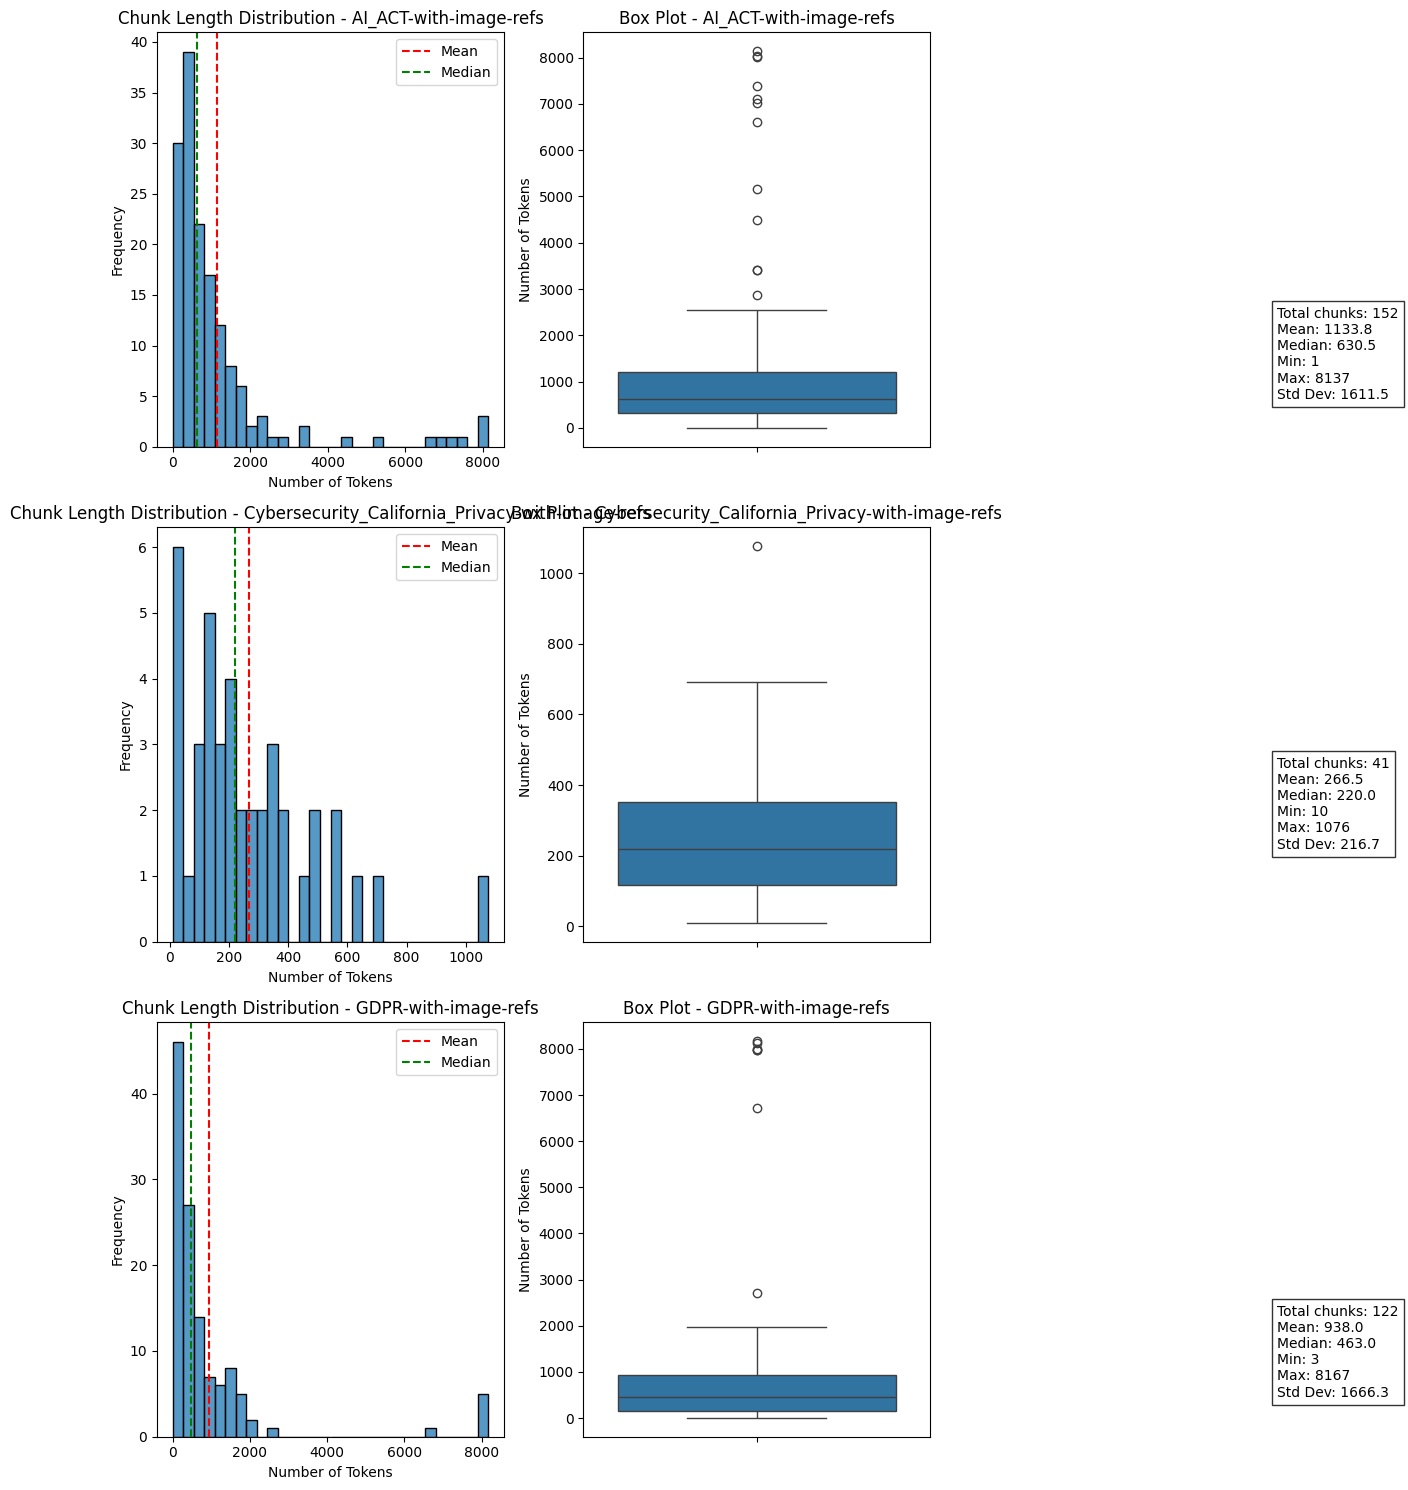


Document Processing Summary:
--------------------------------------------------

AI_ACT-with-image-refs:
  Number of chunks: 152
  Average chunk length: 1133.8 tokens
  Median chunk length: 630.5 tokens
  Min chunk length: 1 tokens
  Max chunk length: 8137 tokens

Cybersecurity_California_Privacy-with-image-refs:
  Number of chunks: 41
  Average chunk length: 266.5 tokens
  Median chunk length: 220.0 tokens
  Min chunk length: 10 tokens
  Max chunk length: 1076 tokens

GDPR-with-image-refs:
  Number of chunks: 122
  Average chunk length: 938.0 tokens
  Median chunk length: 463.0 tokens
  Min chunk length: 3 tokens
  Max chunk length: 8167 tokens

Overall Statistics:
Total number of chunks: 315
Average chunk length: 945.1 tokens
Median chunk length: 479.0 tokens
Standard deviation: 1553.0 tokens


In [5]:
# Generate visualizations and get statistics
chunk_lengths, statistics = analyze_chunk_distribution(
    document_chunks=document_chunks,
    tokenizer=doc_chunker.tokenizer
)

### Analysis:
1. Basic chunker used based on the hierarchical hybrid chunker for markdownfiles
2. Tokenizer used has a maximum context length of 8192 tokens. From the statistics of the chunks it can be observed that the average chunk size is less than 1000.
3. Chunks are not optimised for retieval: No chunk overlap, short term context, long term context, metadata.
4. Multimodal features and embedding not possible
5. Since chunk size much smaller compared to the maximum context length of the tokenizer there is scope for increase in chunk length to optimise it for retrieval

### Future work:
1. Enrich chunk content as to make retrieval accurate and efficient (fit to context length)
2. Cross document chunking to retrieve info for queries that could refer to multiple documents
3. Aggregated info chunks to
4. Chunking with grounding. Short term context in each chunk must have references to the chunks it refers to. Same with long term context


### Indexing 
With the baseline set of chunks, we can now move to indexing strategies. There are a few stragies that can be used for indexing and retrieval:
1. Basic cosine similarity for retrieval: Very fast and easy to understand as doc embeddings are retrieved using vallina cosine similarity (dot product of embedding pairs).
2. BERT similarity cross encoder: Very slow but highly accurate as dense embeddings of document-text pairs are calculated. Not very scalable since the time complexity for retrieval will exponentially increase
3. ColBERT based late interaction: Matches accuracy of BERT based methods without sacrificing on speed of retrieval due to late interaction of embeddings. Dense embeddings are used for better representation and doc embeddings are calculated offline for fater retrieval
4. Vanilla cosine similarity + ColBERT reranker: Here the small set of documents identified by cosine similarity are reranked using the reranker which tends to be more accurate
5. ColBERT + BM25: Since we are using data in the domain of regulation and compoliance, word matching based retrieval could be quite useful in cases where users are looking for relevant documents for a law, sub-section etc

## Experiment 2
Some of the drawbacks of initial method of chunking are the following:
1. There is no overlapping context between the chunks
2. Chunks are not tagged with metadata properly
3. There is no contextual information about the chunks in the chunk itself
4. Markdown files are not standardised so standardisation methods needs to be applied to maintain the structure and metadata across the document

The next series of experiments will focus on creating more meaningful chunks enriched with better context and tagged according to their metadata for better search


In [5]:
# Lets do some EDA on the document to find some descrepencies in the document structure

import re

def analyze_document_structure(file_path, context_lines=2):
    """
    Finds the first 5 occurrences of lines containing #+ CHAPTER, #+ Article, and #+ SECTION
    (where #+ means at least one hash character) and displays them with surrounding context.
    
    Args:
        file_path: Path to the markdown file
        context_lines: Number of lines to display above and below each match
    """
    # Read the file
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    # Search patterns - looking for lines that contain both a hash and the key term
    patterns = [
        (r'#.*CHAPTER', "CHAPTER"),
        (r'#.*Article', "Article"),
        (r'#.*SECTION', "SECTION")
    ]
    
    # Store results for each pattern
    results = {name: [] for _, name in patterns}
    
    # Find occurrences
    for pattern, name in patterns:
        count = 0
        for i, line in enumerate(lines):
            if re.search(pattern, line) and count < 5:
                # Get context lines
                start = max(0, i - context_lines)
                end = min(len(lines), i + context_lines + 1)
                
                # Extract the context
                context = {
                    "line_number": i + 1,
                    "content": line.strip(),
                    "context": [lines[j].strip() for j in range(start, end)]
                }
                
                results[name].append(context)
                count += 1
    
    # Display results
    for name in ["CHAPTER", "Article", "SECTION"]:
        print(f"\n{'=' * 40}")
        print(f"FIRST 5 OCCURRENCES OF '#{name}'")
        print(f"{'=' * 40}")
        
        if not results[name]:
            print(f"No occurrences of '#{name}' found.")
            continue
            
        for idx, occurrence in enumerate(results[name], 1):
            print(f"\nOccurrence #{idx} at line {occurrence['line_number']}:")
            print(f"{'=' * 30}")
            
            for ctx_idx, ctx_line in enumerate(occurrence['context']):
                marker = ">>> " if ctx_line == occurrence['content'] else "    "
                print(f"{marker}{ctx_line}")
            
            print(f"{'=' * 30}")
    
    return results


In [6]:
# Example usage
if __name__ == "__main__":
    analyze_document_structure(".\\processed_docs\\AI_ACT\\AI_ACT\\AI_ACT.md")


FIRST 5 OCCURRENCES OF '#CHAPTER'

Occurrence #1 at line 420:
    HAVE ADOPTED THIS REGULATION:
    
>>> ## CHAPTER I
    
    ## **GENERAL PROVISIONS**

Occurrence #2 at line 571:
    Providers and deployers of AI systems shall take measures to ensure, to their best extent, a sufficient level of AI literacy of their staff and other persons dealing with the operation and use of AI systems on their behalf, taking into account their technical knowledge, experience, education and training and the context the AI systems are to be used in, and considering the persons or groups of persons on whom the AI systems are to be used.
    
>>> ### CHAPTER II
    
    ## **PROHIBITED AI PRACTICES**

Occurrence #3 at line 617:
    8. This Article shall not affect the prohibitions that apply where an AI practice infringes other Union law.
    
>>> # CHAPTER III
    
    # **HIGH-RISK AI SYSTEMS**

Occurrence #4 at line 1470:
    5. High-risk AI systems referred to in point 2 of Annex III shall be regi

### Analysis
- Numbers not closed by () are detected as children whereas items closed are not
- Metadata not getting detected accurately as some headings and sub-heading structure is not clear in the document
- 'Chapters','Articles' and 'Sections' not organised correctly 

# Processing:
- Using marker to split rather than docline: marker_single .\AI_ACT.pdf --output_format markdown --use_llm --gemini_api_key <API_KEY> --output_dir .\
- If CHAPTER term is detected, search next line for chapter name. If Article is detected search next line for article name and so on...
- MD structure: Chapter -> Section -> Article
- Close all numbers between () for uniformity


In [16]:
import re
import logging
from pathlib import Path
from typing import List, Optional, Union

class MarkdownPreprocessor:
    """
    Preprocesses markdown files to standardize formatting for regulatory documents.
    Specifically handles CHAPTER, SECTION, and Article formatting and list numbering.
    """
    
    def __init__(self, log_level: int = logging.INFO):
        """Initialize the preprocessor with logging."""
        self.logger = logging.getLogger(__name__)
        logging.basicConfig(level=log_level, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    
    def process_file(self, input_path: Union[str, Path], output_path: Optional[Union[str, Path]] = None) -> str:
        """
        Process a markdown file and standardize its formatting.
        
        Args:
            input_path: Path to the input markdown file
            output_path: Path where the processed file should be saved (optional)
            
        Returns:
            The processed markdown content as a string
        """
        input_path = Path(input_path)
        
        if not input_path.exists():
            self.logger.error(f"Input file not found: {input_path}")
            raise FileNotFoundError(f"Input file not found: {input_path}")
        
        try:
            # Read the input file
            with open(input_path, 'r', encoding='utf-8') as file:
                content = file.read()
            
            # Process the content
            processed_content = self._process_content(content)
            
            # Save to output file if specified
            if output_path:
                output_path = Path(output_path)
                output_path.parent.mkdir(parents=True, exist_ok=True)
                with open(output_path, 'w', encoding='utf-8') as file:
                    file.write(processed_content)
                self.logger.info(f"Processed markdown saved to: {output_path}")
            
            return processed_content
            
        except Exception as e:
            self.logger.error(f"Error processing file {input_path}: {str(e)}")
            raise
    
    def _process_content(self, content: str) -> str:
        """
        Process the content of a markdown file.
        
        Args:
            content: The content of the markdown file
            
        Returns:
            The processed content
        """
        # Split the content into lines for processing
        lines = content.split('\n')
        
        # Process the lines
        processed_lines = self._process_lines(lines)
        
        # Join the processed lines back into a single string
        return '\n'.join(processed_lines)
    
    def _find_next_non_empty_line(self, lines: List[str], start_index: int) -> tuple:
        """
        Find the next non-empty line starting from a given index.
        
        Args:
            lines: List of all lines
            start_index: Starting index to search from
            
        Returns:
            Tuple of (index of next non-empty line, content of that line)
            If no non-empty line is found, returns (None, None)
        """
        idx = start_index + 1
        while idx < len(lines):
            if lines[idx].strip():
                return idx, lines[idx].strip()
            idx += 1
        return None, None
    
    def _clean_heading_content(self, content: str) -> str:
        """
        Remove leading # characters and clean up the content for use as a heading title.
        
        Args:
            content: The content to clean
            
        Returns:
            The cleaned content
        """
        # Remove all leading # characters
        cleaned = re.sub(r'^#+\s*', '', content)
        return cleaned.strip()
    
    def _process_lines(self, lines: List[str]) -> List[str]:
        """
        Process the lines of a markdown file.
        
        Args:
            lines: The lines of the markdown file
            
        Returns:
            The processed lines
        """
        result = []
        i = 0
        
        while i < len(lines):
            current_line = lines[i].strip()
            
            # Process CHAPTER lines - match lines with # and CHAPTER/Chapter/chapter (case insensitive)
            if re.search(r'#.*[Cc][Hh][Aa][Pp][Tt][Ee][Rr]', current_line):
                # Extract the CHAPTER number using case-insensitive regex
                chapter_num = ""
                chapter_match = re.search(r'[Cc][Hh][Aa][Pp][Tt][Ee][Rr]\s*(.*)', current_line)
                if chapter_match:
                    chapter_num = chapter_match.group(1).strip()
                
                # Create standardized format for the chapter line
                chapter_line = f"## CHAPTER {chapter_num}"
                
                # Find the next non-empty line
                next_idx, next_content = self._find_next_non_empty_line(lines, i)
                
                # Check if there's a non-empty line following that's not a SECTION or Article
                if next_idx is not None and not re.search(r'[Ss][Ee][Cc][Tt][Ii][Oo][Nn]|[Aa][Rr][Tt][Ii][Cc][Ll][Ee]', next_content):
                    # Clean the content by removing any leading # characters
                    cleaned_content = self._clean_heading_content(next_content)
                    chapter_line += f": {cleaned_content}"
                    i = next_idx + 1  # Skip to after the title line
                else:
                    i += 1
                
                result.append(chapter_line)
                continue
            
            # Process Article lines - match lines with # and Article/ARTICLE/article (with or without asterisks)
            elif re.search(r'#.*[Aa][Rr][Tt][Ii][Cc][Ll][Ee]', current_line):
                # Extract the Article number using case-insensitive regex
                article_num = ""
                article_match = re.search(r'(?:\*)?[Aa][Rr][Tt][Ii][Cc][Ll][Ee](?:\*)?\s*(.*)', current_line)
                if article_match:
                    article_num = article_match.group(1).strip()
                
                # Create standardized format for the article line
                article_line = f"#### *Article {article_num}"
                
                # Find the next non-empty line
                next_idx, next_content = self._find_next_non_empty_line(lines, i)
                
                # Check if there's a non-empty line following that's not a CHAPTER or SECTION
                if next_idx is not None and not re.search(r'[Cc][Hh][Aa][Pp][Tt][Ee][Rr]|[Ss][Ee][Cc][Tt][Ii][Oo][Nn]', next_content):
                    # Clean the content by removing any leading # characters
                    cleaned_content = self._clean_heading_content(next_content)
                    article_line += f": {cleaned_content}"
                    i = next_idx + 1  # Skip to after the title line
                else:
                    i += 1
                
                result.append(article_line)
                continue
            
            # Process SECTION lines - match lines with # and SECTION/Section/section (with or without asterisks)
            elif re.search(r'#.*[Ss][Ee][Cc][Tt][Ii][Oo][Nn]', current_line):
                # Extract the SECTION number using case-insensitive regex
                section_num = ""
                section_match = re.search(r'(?:\*)?[Ss][Ee][Cc][Tt][Ii][Oo][Nn](?:\*)?\s*(.*)', current_line)
                if section_match:
                    section_num = section_match.group(1).strip()
                
                # Create standardized format for the section line
                section_line = f"### *SECTION {section_num}"
                
                # Find the next non-empty line
                next_idx, next_content = self._find_next_non_empty_line(lines, i)
                
                # Check if there's a non-empty line following that's not a CHAPTER or Article
                if next_idx is not None and not re.search(r'[Cc][Hh][Aa][Pp][Tt][Ee][Rr]|[Aa][Rr][Tt][Ii][Cc][Ll][Ee]', next_content):
                    # Clean the content by removing any leading # characters
                    cleaned_content = self._clean_heading_content(next_content)
                    section_line += f": {cleaned_content}"
                    i = next_idx + 1  # Skip to after the title line
                else:
                    i += 1
                
                result.append(section_line)
                continue
            
            # Format numbered lists: change "- number." to "- (number)"
            elif current_line.startswith('- ') and re.match(r'- \d+\.', current_line):
                num = re.search(r'- (\d+)\.', current_line).group(1)
                formatted_line = current_line.replace(f"- {num}.", f"- ({num})")
                result.append(formatted_line)
                i += 1
                continue
            
            # Format numbered lists: change "number." at start of line to "(number)"
            elif re.match(r'^\d+\.', current_line):
                num = re.search(r'^(\d+)\.', current_line).group(1)
                formatted_line = current_line.replace(f"{num}.", f"({num})")
                result.append(formatted_line)
                i += 1
                continue
            
            # Add the unchanged line
            result.append(lines[i])
            i += 1
        
        return result

In [ ]:
# Example usage
if __name__ == "__main__":
    preprocessor = MarkdownPreprocessor()
    processed_content = preprocessor.process_file(".\\processed_docs\\AI_ACT\\AI_ACT\\AI_ACT.md", ".\\processed_docs\\AI_ACT\\AI_ACT\\AI_ACT_output.md")


2025-03-01 16:02:00,830 - __main__ - INFO - Processed markdown saved to: processed_docs\AI_ACT\AI_ACT\AI_ACT_output.md


In [18]:

processed_content = preprocessor.process_file(".\\processed_docs\\GDPR\\GDPR\\GDPR.md", ".\\processed_docs\\GDPR\\GDPR\\GDPR_output.md")

2025-03-01 16:05:12,220 - __main__ - INFO - Processed markdown saved to: processed_docs\GDPR\GDPR\GDPR_output.md


### Document preprocessing for Privacy_Act_AU
This document has a bit more convoluted structure compared to the AI Act and GDPR documents for the following reasons:
- The document is a much longer document with about 450 pages
- Complicated page layour with Headers and footers. This makes parsing harder
- Complicated text structure with table of contents divided into Parts -> Divisions -> Sub-divisions -> Sections

Process to standardize the document:
- The reference point to standardize the document is the table of contents. The headings must be represented in a manner that represents its place in the hierarchy in table of contents
- Headers and footers must be removed for accurate storage and retrieval 

In [1]:
###Add rules: 
# Sections start with a number like 20A, Divisions start with the word 'Divisions' and Subdivisions start with 'Subdivisions'. All other 
# heading are extras

import json
from typing import Dict, List, Tuple
import re

def load_toc_json(json_path: str) -> Dict:
    """
    Load TOC JSON and organize into lists of parts, divisions, subdivisions, and sections
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        toc_data = json.load(f)
    
    organized_toc = {
        'Parts': [],
        'Divisions': [],
        'Subdivisions': [],
        'Sections': []
    }
    
    # Process parts and their nested structures
    for part in toc_data['parts']:
        organized_toc['Parts'].append(part['title'])
        
        if part.get('divisions'):
            for div in part['divisions']:
                organized_toc['Divisions'].append(div['title'])
                
                if div.get('sub_divisions'):
                    for subdiv in div['sub_divisions']:
                        organized_toc['Subdivisions'].append(subdiv['title'])
                        if subdiv.get('sections'):
                            for section in subdiv['sections']:
                                organized_toc['Sections'].append(section['title'])
                
                if div.get('sections'):
                    for section in div['sections']:
                        organized_toc['Sections'].append(section['title'])
        
        if part.get('sections'):
            for section in part['sections']:
                organized_toc['Sections'].append(section['title'])
    
    return organized_toc

def identify_heading_type(line: str, toc_dict: Dict) -> Tuple[str, str]:
    """
    Identify if a line is a part, division, subdivision, or section using flexible matching
    and specific heading patterns.
    Returns tuple of (heading_type, original_line)
    """
    # Remove existing heading markers and whitespace
    clean_line = re.sub(r'^#+\s*', '', line.strip())
    
    def normalize_text(text: str) -> str:
        """
        Normalize text by:
        1. Converting to lowercase
        2. Removing special characters and replacing with space
        3. Removing extra whitespace
        4. Removing leading numbers and dots
        """
        # Convert to lowercase
        text = text.lower()
        
        # Replace special characters (-—–) with space
        text = re.sub(r'[-—–]+', ' ', text)
        
        # Remove other special characters
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Remove leading numbers and dots
        text = re.sub(r'^[0-9.]+\s*', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def is_matching_title(line: str, titles: List[str]) -> bool:
        """
        Check if line matches any title using normalized comparison
        """
        normalized_line = normalize_text(line)
        
        for title in titles:
            normalized_title = normalize_text(title)
            # Check if either normalized string contains the other
            if normalized_line in normalized_title or normalized_title in normalized_line:
                return True
        return False
    
    def check_heading_pattern(line: str) -> str:
        """
        Check if line matches specific heading patterns
        Returns heading type or None
        """
        # Remove leading/trailing whitespace
        line = line.strip()
        
        # Check for Part pattern
        if line.lower().startswith('part '):
            return 'Part'
            
        # Check for Division pattern
        if line.lower().startswith('division '):
            return 'Division'
            
        # Check for Subdivision pattern
        if line.lower().startswith('subdivision '):
            return 'Subdivision'
            
        # Check for Section pattern (number followed by title)
        section_pattern = r'^[0-9]+[A-Z]*\s+'  # Matches patterns like "20", "20A", "20WW"
        if re.match(section_pattern, line):
            return 'Section'
            
        return None
    
    # First check specific heading patterns
    pattern_type = check_heading_pattern(clean_line)
    if pattern_type:
        # Verify with flexible matching if pattern is found
        if is_matching_title(clean_line, toc_dict[f'{pattern_type}s']):
            return (pattern_type, clean_line)
    
    # If pattern check fails or doesn't match TOC, try flexible matching alone
    if is_matching_title(clean_line, toc_dict['Parts']):
        return ('Part', clean_line)
    elif is_matching_title(clean_line, toc_dict['Divisions']):
        return ('Division', clean_line)
    elif is_matching_title(clean_line, toc_dict['Subdivisions']):
        return ('Subdivision', clean_line)
    elif is_matching_title(clean_line, toc_dict['Sections']):
        return ('Section', clean_line)
    
    return (None, clean_line)

def process_markdown(input_md_path: str, output_md_path: str, toc_dict: Dict):
    """
    Process markdown file and update heading structure
    """
    heading_levels = {
        'Part': '##',
        'Division': '###',
        'Subdivision': '####',
        'Section': '#####'
    }
    
    with open(input_md_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    processed_lines = []
    for line in lines:
        # Check if line starts with at least one #
        if line.strip().startswith('#'):
            # print(line)
            heading_type, clean_title = identify_heading_type(line, toc_dict)
            if heading_type:
                # print("heading type: ", heading_type, "line: ", line)
                # Replace with correct heading level
                processed_lines.append(f"{heading_levels[heading_type]} {clean_title}\n")
            else:
                print(line)
                # Keep original line if not identified
                processed_lines.append(f"<extra>{line.strip()}</extra>\n")
        else:
            # Keep non-heading lines as is
            processed_lines.append(line)
    
    # Write processed markdown
    with open(output_md_path, 'w', encoding='utf-8') as f:
        f.writelines(processed_lines)

In [2]:
def process_privacy_act_doc():
    # File paths
    json_path = "Experiments/002/toc_data_full_mistral.json"
    input_md_path = "processed_docs\Privacy_Act_AU\Privacy_Act_AU_mistral_extracted.md"
    output_md_path = "processed_docs\Privacy_Act_AU\Privacy_Act_AU_mistral_extracted_v2.md"
    
    # Load and organize TOC
    toc_dict = load_toc_json(json_path)
    
    # Process markdown
    process_markdown(input_md_path, output_md_path, toc_dict)
    
    print(f"Processed markdown has been written to {output_md_path}")

process_privacy_act_doc()

# Privacy Act 1988 

## Compilation No. 101

# About this compilation 

## This compilation

## Uncommenced amendments

## Application, saving and transitional provisions for provisions and amendments

## Editorial changes

## Self-repealing provisions

# Contents 

# An Act to make provision to protect the privacy of individuals, and for related purposes 

# Section 6 

# Section 6 

# Section 6 

# Section 6 

# Section 6 

# Section 6 

# Section 6BA 

## What is an organisation?

# What is a State or Territory authority? 

## What is a small business?

# Test for new business 

## What is a small business operator?

## Entities that are not small business operators

# Section 6DA 

# Section 6E 

## Other credit providers

# Exclusions 

## Consumer credit defaults

## Guarantor defaults

# Section 6QA 

# Section 6S 

## Consumer credit defaults

## Serious credit infringements

# Section 6V 

## Individuals in non-business capacity

# Employee records 

## Journalism

## Organisa

In [7]:
import json
from typing import Dict, List, Tuple
import re

def load_ccpa_toc(json_path: str) -> Dict:
    """
    Load CCPA TOC JSON and organize into lists of main headings and sections
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        toc_data = json.load(f)
    
    organized_toc = {
        'MainHeadings': [],
        'Sections': []
    }
    
    # Process main headings and their sections
    for item in toc_data['ccpaTOC']:
        organized_toc['MainHeadings'].append(item['main_heading'])
        if item.get('section'):
            for section in item['section']:
                organized_toc['Sections'].append(section['title'])
    
    return organized_toc

def normalize_text(text: str) -> str:
    """
    Normalize text by:
    1. Converting to lowercase
    2. Removing special characters
    3. Removing extra whitespace
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def identify_heading_type(line: str, toc_dict: Dict) -> Tuple[str, str]:
    """
    Identify if a line is a main heading, section, or compliance recommendations
    Returns tuple of (heading_type, original_line)
    """
    # Remove existing heading markers and whitespace
    clean_line = re.sub(r'^#+\s*', '', line.strip())
    
    # Check for Compliance Recommendations first
    if 'compliance recommendations' in clean_line.lower():
        return ('ComplianceRecommendations', clean_line)
    
    def is_matching_title(line: str, titles: List[str]) -> bool:
        """
        Check if line matches any title using normalized comparison
        """
        normalized_line = normalize_text(line)
        
        for title in titles:
            normalized_title = normalize_text(title)
            # Check if either normalized string contains the other
            if normalized_line in normalized_title or normalized_title in normalized_line:
                return True
        return False
    
    # Check for main heading
    if is_matching_title(clean_line, toc_dict['MainHeadings']):
        return ('MainHeading', clean_line)
    # Then check for section
    elif is_matching_title(clean_line, toc_dict['Sections']):
        return ('Section', clean_line)
    
    return (None, clean_line)

def process_ccpa_markdown(input_md_path: str, output_md_path: str, toc_dict: Dict):
    """
    Process CCPA markdown file and update heading structure
    """
    heading_levels = {
        'MainHeading': '##',
        'Section': '###',
        'ComplianceRecommendations': '####'
    }
    
    with open(input_md_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    processed_lines = []
    last_section_index = -1  # Track the last section heading
    
    # First pass to identify sections
    section_indices = []
    for i, line in enumerate(lines):
        if line.strip().startswith('#'):
            heading_type, _ = identify_heading_type(line, toc_dict)
            if heading_type == 'Section':
                section_indices.append(i)
    
    for i, line in enumerate(lines):
        # Check if line starts with at least one #
        if line.strip().startswith('#'):
            heading_type, clean_title = identify_heading_type(line, toc_dict)
            
            if heading_type == 'ComplianceRecommendations':
                # Check if this line is between two sections
                is_between_sections = False
                for j in range(len(section_indices) - 1):
                    if section_indices[j] < i < section_indices[j + 1]:
                        is_between_sections = True
                        break
                
                if is_between_sections:
                    # Format as section-level heading
                    processed_lines.append(f"{heading_levels[heading_type]} {clean_title}\n")
                else:
                    # Wrap in extra tags if not between sections
                    processed_lines.append(f"<extra>{line.strip()}</extra>\n")
            elif heading_type:
                # Replace with correct heading level but keep original line content
                processed_lines.append(f"{heading_levels[heading_type]} {clean_title}\n")
            else:
                # Wrap undetected heading with <extra> tags
                processed_lines.append(f"<extra>{line.strip()}</extra>\n")
        else:
            # Keep non-heading lines as is
            processed_lines.append(line)
    
    # Write processed markdown
    with open(output_md_path, 'w', encoding='utf-8') as f:
        f.writelines(processed_lines)



In [8]:
def process_ccpa():
    # File paths
    json_path = "Experiments/002/toc_data_ccpa.json"
    input_md_path = "processed_docs/Cybersecurity_California_Privacy/Cybersecurity_California_Privacy_extracted.md"
    output_md_path = "processed_docs/Cybersecurity_California_Privacy/Cybersecurity_California_Privacy_processed.md"
    
    # Load and organize TOC
    toc_dict = load_ccpa_toc(json_path)
    
    # Process markdown
    process_ccpa_markdown(input_md_path, output_md_path, toc_dict)
    
    print(f"Processed markdown has been written to {output_md_path}")

process_ccpa()

Processed markdown has been written to processed_docs/Cybersecurity_California_Privacy/Cybersecurity_California_Privacy_processed.md


### Changes done:
- The 4 documents are now processed to have a hierarcal heading structure
- This will allow for more meaningful documents into chunks for storage
- It will also allow for better metadata for faster and more accurate search
- Since chunks are more meaningful, chunks can now be enriched with information such as previous section details, next section
details, chunk summaries
- Knowledge graph approach can be explored

The next step is to use the document chunker to chunk the documents. We will use the same chunker that has been created above for now 

In [10]:
# Initialize the chunker with the specific file pattern
doc_chunker = DocumentChunker(file_ext="**/*_002.md")

# Process all documents
document_chunks = doc_chunker.process_directory()

# Print statistics
doc_chunker.get_document_statistics()

INFO:__main__:Found 4 markdown files to process
INFO:__main__:Processing AI_ACT\AI_ACT_output_002.md
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.pipeline.base_pipeline:Processing document AI_ACT_output_002.md
INFO:docling.document_converter:Finished converting document AI_ACT_output_002.md in 15.27 sec.
Token indices sequence length is longer than the specified maximum sequence length for this model (8227 > 8192). Running this sequence through the model will result in indexing errors
INFO:__main__:Successfully processed AI_ACT_output_002.md - Generated 139 chunks
INFO:__main__:Processing Cybersecurity_California_Privacy\Cybersecurity_California_Privacy_002.md
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.pipeline.base_pipeline:Processing document Cybersecurity_California_Privacy_002.md
INFO:docling.document_converter:Finished converting document Cybersecurity_California_Privacy_002.md in 1.49 sec.
INFO:__main__:Succe


Document Processing Statistics:
------------------------------

Document: AI_ACT_output_002
Number of chunks: 139
Average chunk length: 749.03 tokens

Document: Cybersecurity_California_Privacy_002
Number of chunks: 29
Average chunk length: 359.00 tokens

Document: GDPR_output_002
Number of chunks: 107
Average chunk length: 606.62 tokens

Document: Privacy_Act_AU_mistral_extracted_002
Number of chunks: 368
Average chunk length: 365.29 tokens


In [29]:
print(document_chunks['Privacy_Act_AU_mistral_extracted_002'][0])

<extra># Privacy Act 1988</extra>  
No. 119, 1988  
<extra>## Compilation No. 101</extra>  
Compilation date: 11 December 2024
Includes amendments: Act No. 128, 2024  
<extra># About this compilation</extra>  
<extra>## This compilation</extra>  
This is a compilation of the Privacy Act 1988 that shows the text of the law as amended and in force on 11 December 2024 (the compilation date).  
The notes at the end of this compilation (the endnotes) include information about amending laws and the amendment history of provisions of the compiled law.  
<extra>## Uncommenced amendments</extra>  
The effect of uncommenced amendments is not shown in the text of the compiled law. Any uncommenced amendments affecting the law are accessible on the Register (www.legislation.gov.au). The details of amendments made up to, but not commenced at, the compilation date are underlined in the endnotes. For more information on any uncommenced amendments, see the Register for the compiled law.  
<extra>## App

In [18]:
import json
import os

experiment_dir = '.\\Experiments\\002'
# Prepare list to store all chunks with their metadata
chunks_data = []

# Loop through the document_chunks dictionary
for doc_name, chunks in document_chunks.items():
    # Process each chunk in the document
    for i, chunk_content in enumerate(chunks):
        chunk_data = {
            "document_name": doc_name,
            "chunk_id": f"{doc_name}_chunk_{i}",
            "chunk_content": chunk_content
        }
        chunks_data.append(chunk_data)

# Save to JSON file
output_path = os.path.join(experiment_dir, "document_chunks.json")
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(chunks_data, f, indent=2, ensure_ascii=False)

print(f"Saved {len(chunks_data)} chunks to {output_path}")

Saved 643 chunks to .\Experiments\002\document_chunks.json


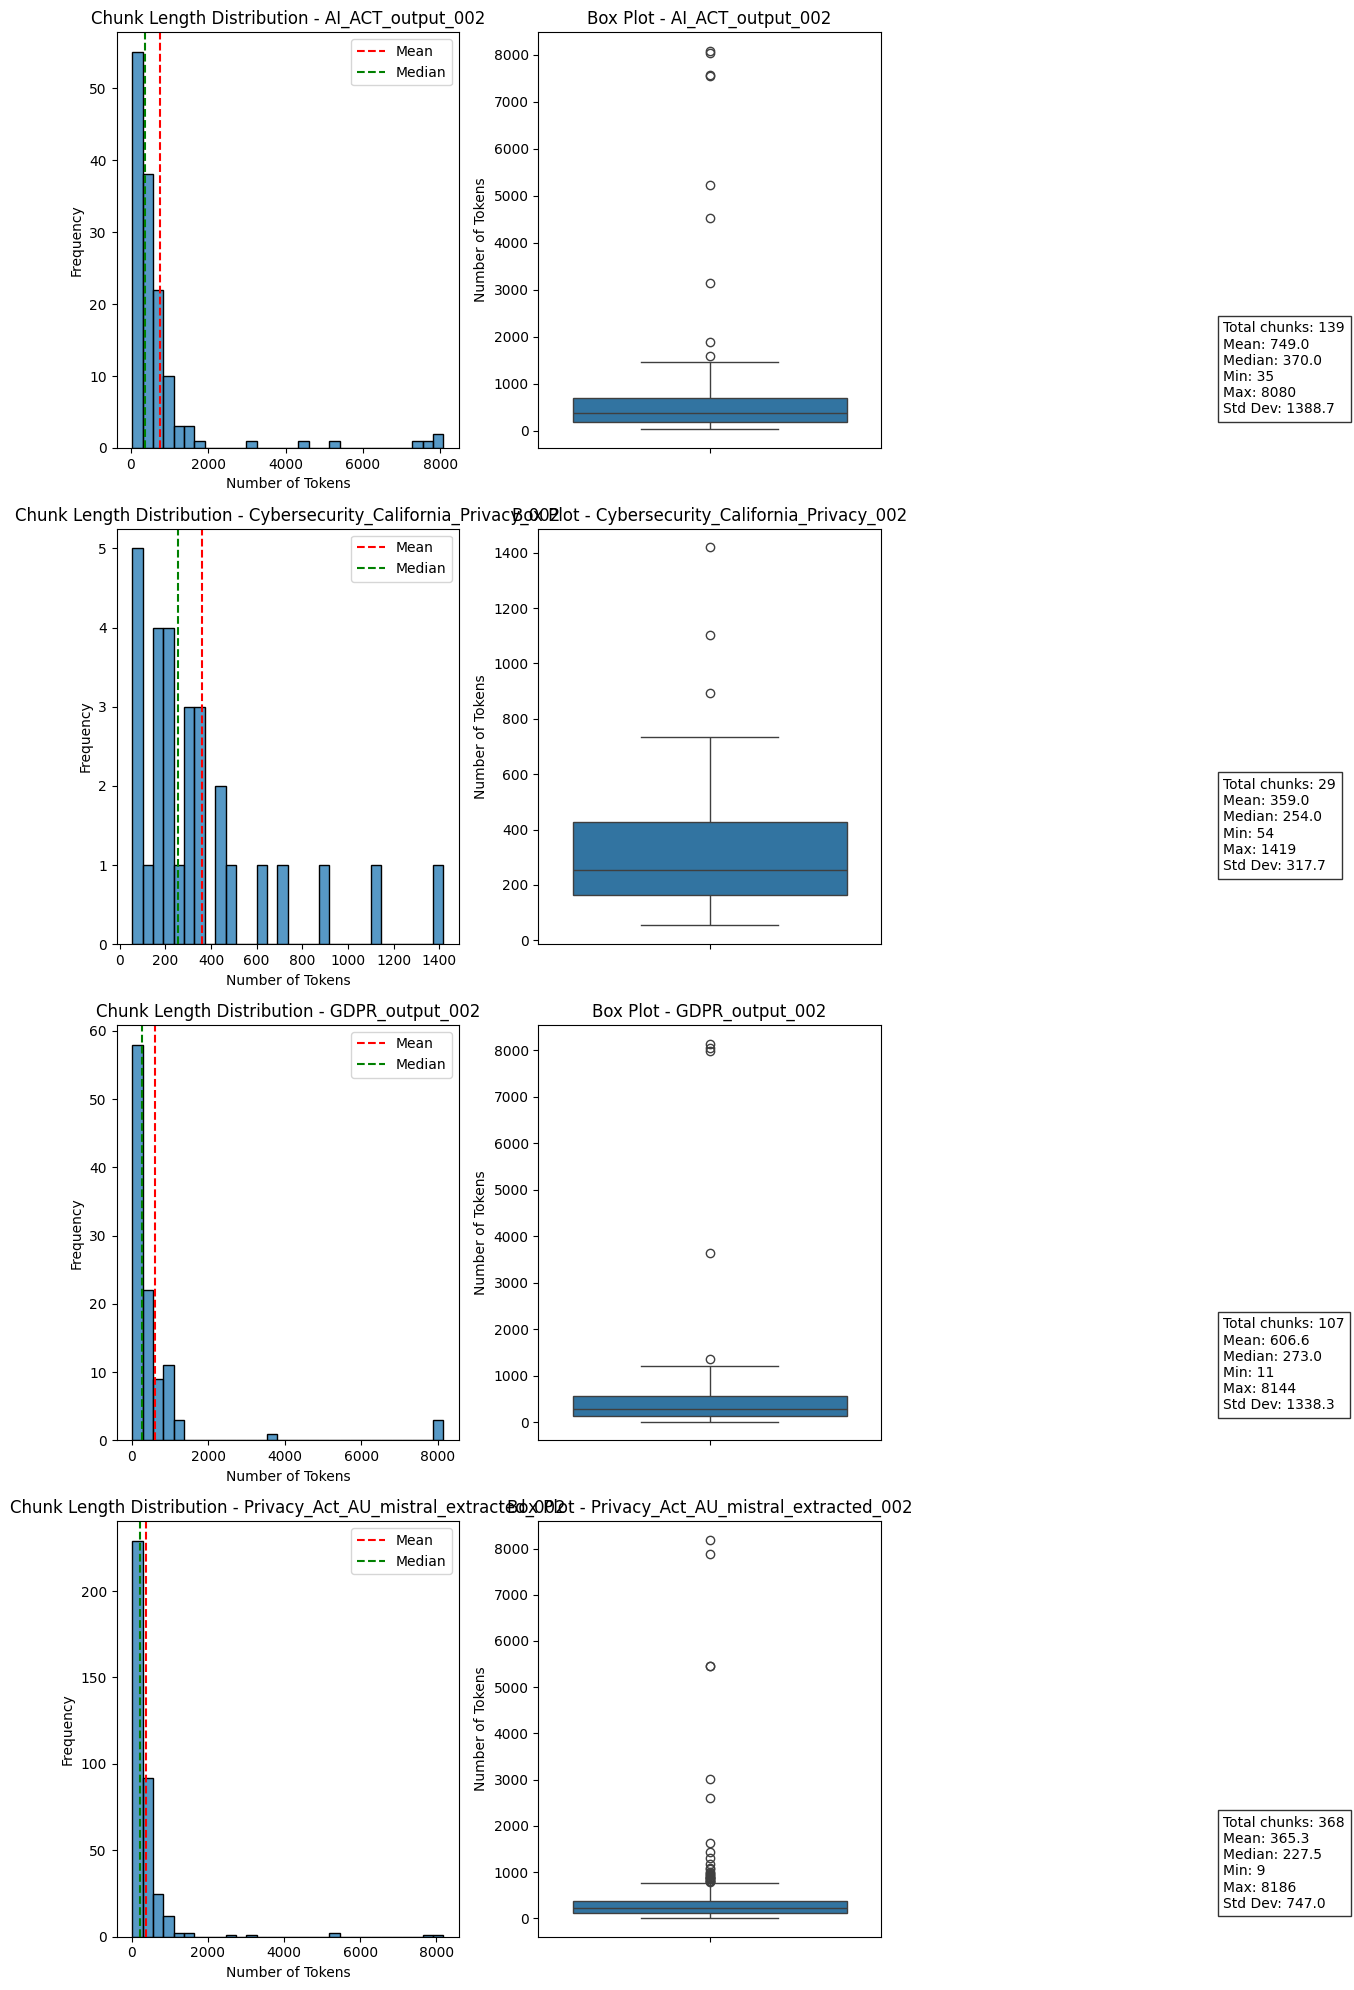


Document Processing Summary:
--------------------------------------------------

AI_ACT_output_002:
  Number of chunks: 139
  Average chunk length: 749.0 tokens
  Median chunk length: 370.0 tokens
  Min chunk length: 35 tokens
  Max chunk length: 8080 tokens

Cybersecurity_California_Privacy_002:
  Number of chunks: 29
  Average chunk length: 359.0 tokens
  Median chunk length: 254.0 tokens
  Min chunk length: 54 tokens
  Max chunk length: 1419 tokens

GDPR_output_002:
  Number of chunks: 107
  Average chunk length: 606.6 tokens
  Median chunk length: 273.0 tokens
  Min chunk length: 11 tokens
  Max chunk length: 8144 tokens

Privacy_Act_AU_mistral_extracted_002:
  Number of chunks: 368
  Average chunk length: 365.3 tokens
  Median chunk length: 227.5 tokens
  Min chunk length: 9 tokens
  Max chunk length: 8186 tokens

Overall Statistics:
Total number of chunks: 643
Average chunk length: 488.1 tokens
Median chunk length: 262.0 tokens
Standard deviation: 1032.1 tokens


In [20]:
# Lets analyse the token length distribution

# Generate visualizations and get statistics
chunk_lengths, statistics = analyze_chunk_distribution(
    document_chunks=document_chunks,
    tokenizer=doc_chunker.tokenizer
)

### Analysis:
- From experiment 1, for most documents the median chunk size has becomes shorter.
- Since chunks are more meaningful due to the processing applied, chunks are now shorter
- The next steps is to extract the metadata from the chunks

In [51]:
from pathlib import Path
import logging
from typing import Dict, List, Any
from transformers import AutoTokenizer
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_core.documents import Document

class MarkdownChunker:
    def __init__(self, file_ext: str, base_dir: str = "processed_docs", 
                 model_id: str = "answerdotai/ModernBERT-base",
                 merge_peers: bool = True,
                 max_tokens: int = None):
        """
        Initialize the MarkdownChunker.
        
        Args:
            file_ext: File extension pattern to match markdown files
            base_dir: Base directory containing markdown files
            model_id: Tokenizer model ID to use
            merge_peers: Whether to merge undersized consecutive chunks with matching metadata
            max_tokens: Maximum tokens per chunk (defaults to model's max length)
        """
        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
        self.base_dir = Path(base_dir)
        self.model_id = model_id
        self.file_ext = file_ext
        self.merge_peers = merge_peers
        self.custom_max_tokens = max_tokens
        
        # Initialize components
        self._setup_components()
        
        # Store results
        self.document_chunks: Dict[str, Dict[str, Dict[str, Any]]] = {}

    def _setup_components(self) -> None:
        """Initialize tokenizer and markdown splitter"""
        # Initialize tokenizer first
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_id)
        self.max_tokens = self.custom_max_tokens or self.tokenizer.model_max_length
        
        self.headers_to_split_on = [
            ("#", "Header 1"),
            ("##", "Header 2"),
            ("###", "Header 3"),
            ("####", "Header 4"),
            ("#####", "Header 5")
        ]
        
        self.markdown_splitter = MarkdownHeaderTextSplitter(
            headers_to_split_on=self.headers_to_split_on
        )

    def _count_tokens(self, text: str) -> int:
        """Count tokens in a text string using the tokenizer"""
        return len(self.tokenizer.tokenize(text))
    
    def _should_split_chunk(self, content: str) -> bool:
        """Check if a chunk needs splitting based on token count"""
        return self._count_tokens(content) > self.max_tokens
    
    def _split_text_by_tokens(self, text: str, metadata: Dict) -> List[Dict[str, Any]]:
        """
        Split text into chunks that respect the token limit.
        Returns list of chunks with their metadata.
        """
        chunks = []
        current_chunk = []
        current_length = 0
        
        # Split into paragraphs first
        paragraphs = text.split('\n\n')
        
        for para in paragraphs:
            # Skip empty paragraphs
            if not para.strip():
                continue
                
            # Further split paragraphs if they're too long
            if self._count_tokens(para) > self.max_tokens:
                # First try splitting by sentences
                sentences = [s.strip() + '.' for s in para.split('.') if s.strip()]
                
                for sentence in sentences:
                    sentence_tokens = self._count_tokens(sentence)
                    
                    if sentence_tokens > self.max_tokens:
                        # If a single sentence is too long, split by words
                        words = sentence.split()
                        current_sentence = []
                        current_sentence_tokens = 0
                        
                        for word in words:
                            word_tokens = self._count_tokens(word)
                            if current_sentence_tokens + word_tokens + 1 <= self.max_tokens:
                                current_sentence.append(word)
                                current_sentence_tokens += word_tokens + 1
                            else:
                                # Add current sentence to chunks
                                if current_sentence:
                                    sentence_text = ' '.join(current_sentence)
                                    chunks.append({
                                        "content": sentence_text,
                                        "metadata": metadata
                                    })
                                current_sentence = [word]
                                current_sentence_tokens = word_tokens
                        
                        if current_sentence:
                            sentence_text = ' '.join(current_sentence)
                            chunks.append({
                                "content": sentence_text,
                                "metadata": metadata
                            })
                    else:
                        # Handle regular sentences
                        if current_length + sentence_tokens <= self.max_tokens:
                            current_chunk.append(sentence)
                            current_length += sentence_tokens
                        else:
                            if current_chunk:
                                chunks.append({
                                    "content": ' '.join(current_chunk),
                                    "metadata": metadata
                                })
                            current_chunk = [sentence]
                            current_length = sentence_tokens
            else:
                # Handle regular paragraphs
                para_tokens = self._count_tokens(para)
                if current_length + para_tokens + 2 <= self.max_tokens:  # +2 for newlines
                    current_chunk.append(para)
                    current_length += para_tokens + 2
                else:
                    if current_chunk:
                        chunks.append({
                            "content": '\n\n'.join(current_chunk),
                            "metadata": metadata
                        })
                    current_chunk = [para]
                    current_length = para_tokens
        
        # Add any remaining content
        if current_chunk:
            chunks.append({
                "content": '\n\n'.join(current_chunk),
                "metadata": metadata
            })
        
        return chunks
    
    def _merge_similar_chunks(self, chunks: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """Merge consecutive chunks with matching metadata if they're undersized"""
        if not self.merge_peers or len(chunks) <= 1:
            return chunks
            
        merged_chunks = []
        current_chunk = chunks[0]
        
        for next_chunk in chunks[1:]:
            # Check if metadata matches (headers should be the same)
            combined_content = current_chunk['content'] + '\n\n' + next_chunk['content']
            if (current_chunk['metadata'] == next_chunk['metadata'] and 
                self._count_tokens(combined_content) <= self.max_tokens):
                # Merge chunks
                current_chunk['content'] = combined_content
            else:
                merged_chunks.append(current_chunk)
                current_chunk = next_chunk
                
        merged_chunks.append(current_chunk)
        return merged_chunks

    def process_single_document(self, file_path: Path) -> Dict[str, Dict[str, Any]]:
        """Process a single markdown file with token-aware splitting and merging"""
        doc_chunks = {}
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                markdown_content = f.read()
            
            # Initial split using markdown headers
            split_docs = self.markdown_splitter.split_text(markdown_content)
            
            # Convert to our internal format and handle oversized chunks
            temp_chunks = []
            for doc in split_docs:
                if self._should_split_chunk(doc.page_content):
                    # Use the new splitting function
                    sub_chunks = self._split_text_by_tokens(doc.page_content, doc.metadata)
                    temp_chunks.extend(sub_chunks)
                else:
                    temp_chunks.append({
                        "content": doc.page_content,
                        "metadata": doc.metadata
                    })
            
            # Merge undersized chunks if enabled
            final_chunks = self._merge_similar_chunks(temp_chunks)
            
            # Create final chunk dictionary
            for i, chunk in enumerate(final_chunks):
                chunk_id = f"{file_path.stem}_chunk_{i}"
                doc_chunks[chunk_id] = chunk
            
            self.logger.info(f"Successfully processed {file_path.name} - Generated {len(doc_chunks)} chunks")
            
        except Exception as e:
            self.logger.error(f"Error processing {file_path.name}: {str(e)}")
            raise  # Re-raise the exception for better error handling
        
        return doc_chunks

    def process_directory(self) -> Dict[str, Dict[str, Dict[str, Any]]]:
        """Process all markdown files in the directory"""
        md_files = list(self.base_dir.glob(self.file_ext))
        
        if not md_files:
            self.logger.warning(f"No markdown files found in {self.base_dir}")
            return self.document_chunks
        
        self.logger.info(f"Found {len(md_files)} markdown files to process")
        
        for md_file in md_files:
            self.logger.info(f"Processing {md_file.relative_to(self.base_dir)}")
            doc_key = md_file.stem
            self.document_chunks[doc_key] = self.process_single_document(md_file)
        
        self.logger.info(f"Completed processing all documents")
        return self.document_chunks

In [30]:
def preprocess_chunks_for_analysis(document_chunks: Dict[str, Dict[str, Dict[str, Any]]]) -> Dict[str, List[str]]:
    """
    Convert the nested dictionary structure of chunks into the format required by analyze_chunk_distribution.
    
    Args:
        document_chunks: Dictionary with structure {doc_name: {chunk_id: {"content": str, "metadata": dict}}}
        
    Returns:
        Dictionary with structure {doc_name: [chunk_content_1, chunk_content_2, ...]}
    """
    processed_chunks = {}
    
    for doc_name, chunks in document_chunks.items():
        # Extract just the content from each chunk, maintaining the order using chunk IDs
        chunk_ids = sorted(chunks.keys())  # Ensures consistent ordering
        processed_chunks[doc_name] = [chunks[chunk_id]["content"] for chunk_id in chunk_ids]
    
    return processed_chunks

INFO:__main__:Found 4 markdown files to process
INFO:__main__:Processing AI_ACT\AI_ACT_output_002.md
Token indices sequence length is longer than the specified maximum sequence length for this model (10015 > 8192). Running this sequence through the model will result in indexing errors
INFO:__main__:Successfully processed AI_ACT_output_002.md - Generated 141 chunks
INFO:__main__:Processing Cybersecurity_California_Privacy\Cybersecurity_California_Privacy_002.md
INFO:__main__:Successfully processed Cybersecurity_California_Privacy_002.md - Generated 29 chunks
INFO:__main__:Processing GDPR\GDPR_output_002.md
INFO:__main__:Successfully processed GDPR_output_002.md - Generated 107 chunks
INFO:__main__:Processing Privacy_Act_AU\Privacy_Act_AU_mistral_extracted_002.md
INFO:__main__:Successfully processed Privacy_Act_AU_mistral_extracted_002.md - Generated 369 chunks
INFO:__main__:Completed processing all documents


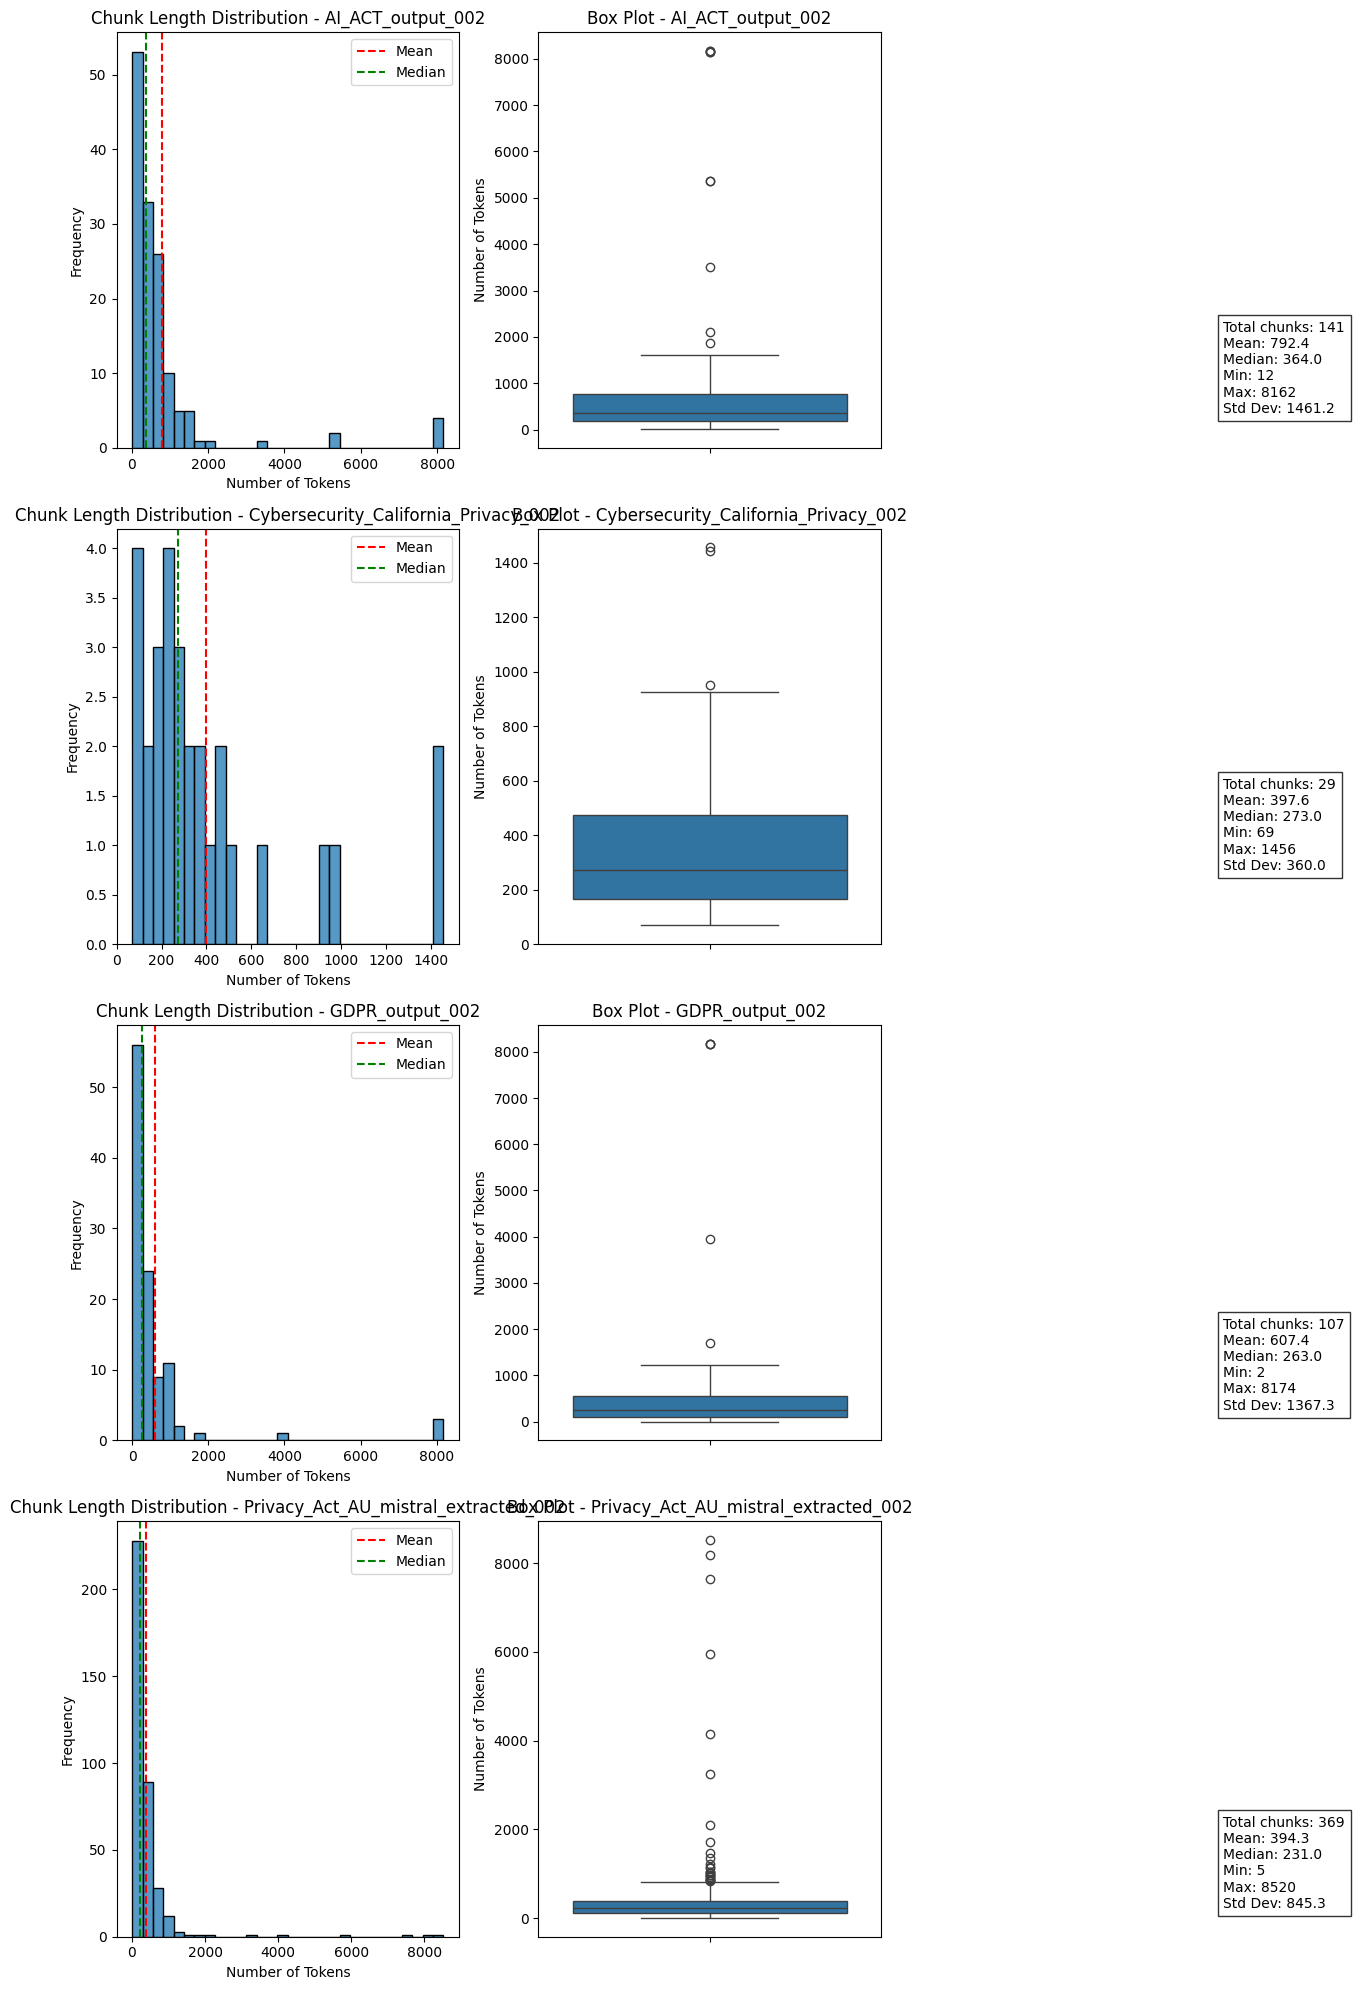


Document Processing Summary:
--------------------------------------------------

AI_ACT_output_002:
  Number of chunks: 141
  Average chunk length: 792.4 tokens
  Median chunk length: 364.0 tokens
  Min chunk length: 12 tokens
  Max chunk length: 8162 tokens

Cybersecurity_California_Privacy_002:
  Number of chunks: 29
  Average chunk length: 397.6 tokens
  Median chunk length: 273.0 tokens
  Min chunk length: 69 tokens
  Max chunk length: 1456 tokens

GDPR_output_002:
  Number of chunks: 107
  Average chunk length: 607.4 tokens
  Median chunk length: 263.0 tokens
  Min chunk length: 2 tokens
  Max chunk length: 8174 tokens

Privacy_Act_AU_mistral_extracted_002:
  Number of chunks: 369
  Average chunk length: 394.3 tokens
  Median chunk length: 231.0 tokens
  Min chunk length: 5 tokens
  Max chunk length: 8520 tokens

Overall Statistics:
Total number of chunks: 646
Average chunk length: 516.6 tokens
Median chunk length: 263.0 tokens
Standard deviation: 1103.1 tokens


In [52]:
# Example usage
chunker = MarkdownChunker(file_ext="**/*_002.md", merge_peers=True)
document_chunks = chunker.process_directory()

analysis_chunks = preprocess_chunks_for_analysis(document_chunks)

# Debug print to verify chunks
# for doc_name, chunks in document_chunks.items():
#     print(f"\nDocument: {doc_name}")
#     print(f"Number of chunks: {len(chunks)}")
#     if chunks:
#         first_chunk_id = next(iter(chunks))
#         chunk = chunks[first_chunk_id]
#         print(f"Sample chunk content length: {len(chunk['content'])}")
#         print(f"Sample metadata: {chunk['metadata']}")

# Use the original analyze_chunk_distribution function
chunk_distributions, statistics = analyze_chunk_distribution(analysis_chunks, chunker.tokenizer)

In [55]:
document_chunks['AI_ACT_output_002']['AI_ACT_output_002_chunk_6']

{'content': 'The definition should be based on the key functional characteristics of a general-purpose AI model, in particular the generality and the capability to competently perform a wide range of distinct tasks.\n\nThese models are typically trained on large amounts of data, through various methods, such as self-supervised, unsupervised or reinforcement learning.\n\nGeneral-purpose AI models may be placed on the market in various ways, including through libraries, application programming interfaces (APIs), as direct download, or as physical copy.\n\nThese models may be further modified or fine-tuned into new models.\n\nAlthough AI models are essential components of AI systems, they do not constitute AI systems on their own.\n\nAI models require the addition of further components, such as for example a user interface, to become AI systems.\n\nAI models are typically integrated into and form part of AI systems.\n\nThis Regulation provides specific rules for general-purpose AI models 

In [56]:
import json
from pathlib import Path
from typing import Dict, Any

def save_chunks_to_json(document_chunks: Dict[str, Dict[str, Dict[str, Any]]], 
                       output_file: str = "chunks.json") -> None:
    """
    Save all chunks to a single JSON file with specified structure.
    
    Args:
        document_chunks: The chunks dictionary from MarkdownChunker
        output_file: Name of the output JSON file
    """
    # Create list to store all chunks
    all_chunks = []
    
    # Process each document and its chunks
    for doc_name, chunks in document_chunks.items():
        for chunk_id, chunk_data in chunks.items():
            chunk = {
                "chunk_id": chunk_id,
                "chunk_content": chunk_data["content"],
                "chunk_metadata": chunk_data["metadata"]
            }
            all_chunks.append(chunk)
    
    # Create output directory if it doesn't exist
    output_path = Path(output_file)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Save to JSON file
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(all_chunks, f, indent=2, ensure_ascii=False)
    
    print(f"Saved {len(all_chunks)} chunks to {output_file}")

# Example usage:


In [57]:
save_chunks_to_json(
    document_chunks=document_chunks,
    output_file="Experiments/002/document_chunks.json"
)

Saved 646 chunks to Experiments/002/document_chunks.json


### Experiment 3
Will contain the following data processing:
- Content enrishment of chunks:
- Clean metadata -> Knowledge graph